### Problem description
Data from: https://www.kaggle.com/camnugent/california-housing-prices?select=housing.csv

The data pertains to the houses found in a given California district and some summary stats about them based on the year 1990 census data. I have tried to build a model that can predict the housing prices in this area by training on the mentioned data set.

Data Dictionary :

1. **longitude:** A measure of how far west a house is; a higher value is farther west
2. **latitude:** A measure of how far north a house is; a higher value is farther north
3. **housingMedianAge:** Median age of a house within a block; a lower number is a newer building
4. **totalRooms:** Total number of rooms within a block
5. **totalBedrooms:** Total number of bedrooms within a block
6. **population:** Total number of people residing within a block
7. **households:** Total number of households, a group of people residing within a home unit, for a block
8. **medianIncome:** Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. **medianHouseValue:** Median house value for households within a block (measured in US Dollars)
10. **oceanProximity:** Location of the house w.r.t ocean/sea


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xgboost

**Reading the dataset.**

In [2]:
houses = pd.read_csv('housing.csv')
houses.insert(0,'Id',houses.index)
houses.head()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**Exploratory Data Analysis of all features**

In [3]:
print(houses.shape)
houses.info()

(20640, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
Id                    20640 non-null int64
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), int64(1), object(1)
memory usage: 1.7+ MB


**The dataset contains 20640 rows and 10 columns**

**We can see that total_bedrooms has few missing values. Before selecting the model, we need to have all non nan values. To retain the other data points of these missing values rows, we will impute them with the mean value.**

In [6]:
houses['total_bedrooms'].value_counts()


537.870553     207
280.000000      55
331.000000      51
345.000000      50
343.000000      49
393.000000      49
328.000000      48
394.000000      48
348.000000      48
272.000000      47
309.000000      47
295.000000      46
322.000000      46
399.000000      46
314.000000      46
317.000000      46
291.000000      45
346.000000      45
290.000000      45
340.000000      45
313.000000      45
287.000000      45
284.000000      45
388.000000      45
294.000000      44
300.000000      44
361.000000      44
390.000000      44
312.000000      44
269.000000      44
              ... 
5471.000000      1
2370.000000      1
1687.000000      1
1842.000000      1
1652.000000      1
1246.000000      1
6445.000000      1
2020.000000      1
2460.000000      1
1661.000000      1
3479.000000      1
1103.000000      1
1647.000000      1
2453.000000      1
1494.000000      1
1619.000000      1
1877.000000      1
2812.000000      1
1166.000000      1
1440.000000      1
1376.000000      1
1481.000000 

In [5]:
houses['total_bedrooms'].fillna(houses['total_bedrooms'].mean(), inplace = True)
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
Id                    20640 non-null int64
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20640 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), int64(1), object(1)
memory usage: 1.7+ MB


## We can see that there are no more null values.

In [7]:
houses.describe()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,10319.500000,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,5958.399114,2.003532,2.135952,12.585558,2181.615252,419.266592,1132.462122,382.329753,1.899822,115395.615874
min,0.000000,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,5159.750000,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000
50%,10319.500000,-118.490000,34.260000,29.000000,2127.000000,438.000000,1166.000000,409.000000,3.534800,179700.000000
75%,15479.250000,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000
max,20639.000000,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Feature Selection - 
Checking for correlation amongst all features 

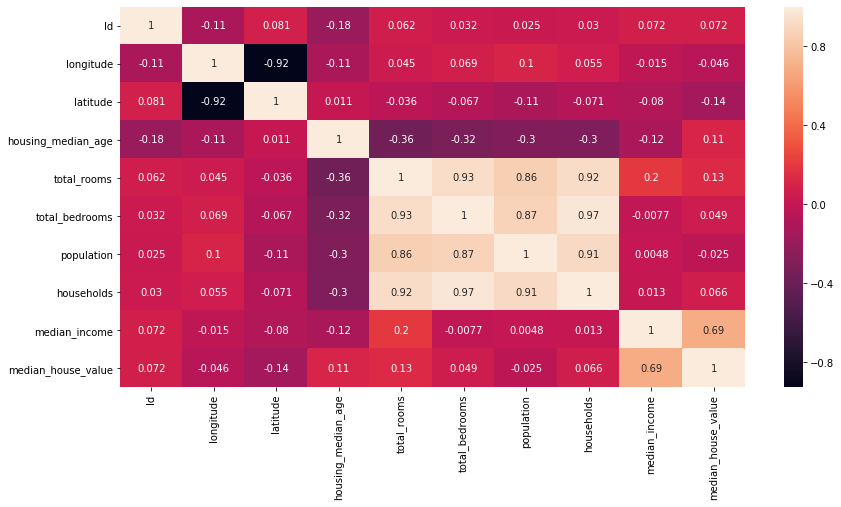

In [8]:
f , ax = plt.subplots(figsize = (14,7))
ax = sns.heatmap(houses.corr(), annot=True)
plt.show()

**Here, we can see that the house value is highly correlated to median_income and households. Households in turn is highly correlated with population, total_bedrooms and total_rooms.**

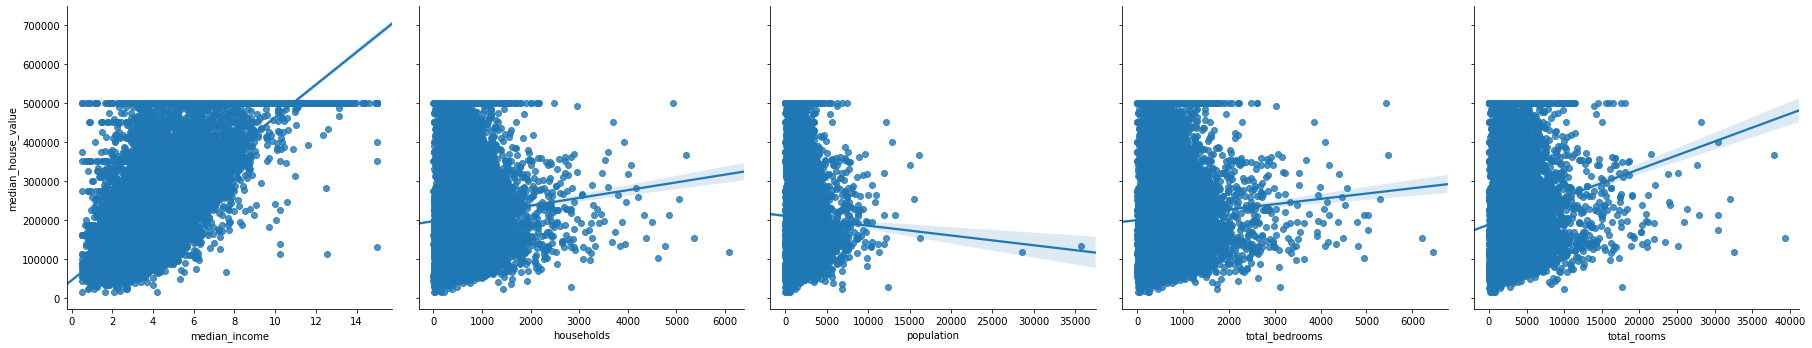

In [9]:
sns.pairplot(houses, x_vars=['median_income','households','population','total_bedrooms','total_rooms'], 
             y_vars=['median_house_value'], height=5, kind='reg')


**It is also important to Check for overfitting columns and drop the columns where the frequency of certain values are more than 99% of all column values.**

In [10]:
def overfit_features(df,weight):
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts() #frequency of each value in the column
        max_val_count = counts.iloc[0] #the maximum no. of times a value has been repeated in the column
        if max_val_count / len(df) * 100 > weight: #checking if more than 99% of the values in the column are same
            overfit.append(i) #column added to 'overfit' becomes redundant as it has 99% rows with same value. So, it can be dropped. 
    overfit = list(overfit)
    return overfit


print(overfit_features(houses,99))

[]


**Since there are no overfit features, we need not drop any column**

**Exploring categorical feature 'ocean_proximity.**

In [11]:
houses['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

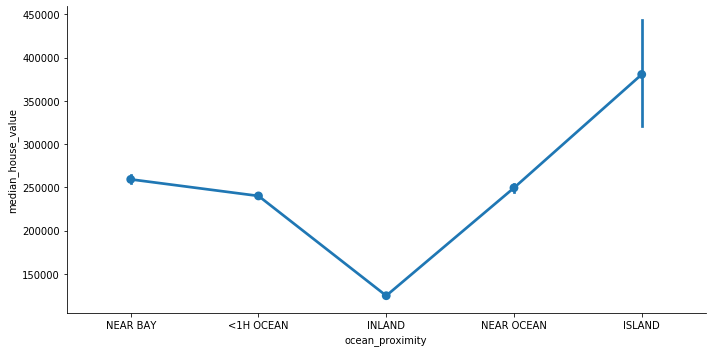

In [12]:
sns.catplot(x='ocean_proximity', y='median_house_value', data=houses, kind='point', aspect=2,)

**We can see here that a house value increases as it gets nearer to the ocean**

**ocean_proximity has non numeric values. So we will add another column with numeric values to map ocean_proximity.**

In [13]:
# Adding a new column ocean_proximity_num
ocean_proximity_num = {'<1H OCEAN':2, 'INLAND':1, 'NEAR OCEAN':3, 'NEAR BAY':4, 'ISLAND':5}
houses['ocean_proximity_num'] = houses['ocean_proximity'].map(ocean_proximity_num)
houses.head()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_num
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,4
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,4
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,4
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,4


In [14]:
# Dropping ocean_proximity column as it is redundant now
houses.drop('ocean_proximity', axis=1, inplace=True)
houses.head()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_num
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,4
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,4
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,4
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,4
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,4


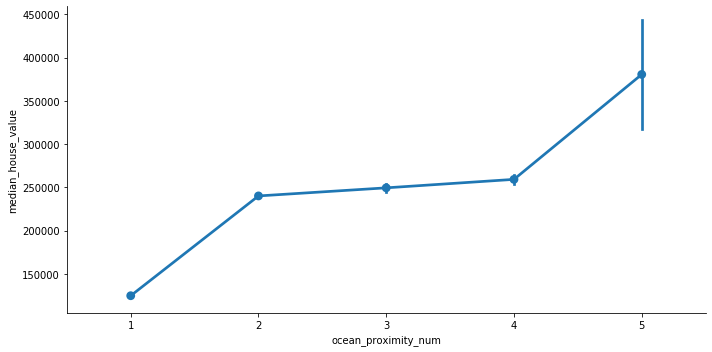

In [15]:
sns.catplot(x='ocean_proximity_num', y='median_house_value', data=houses, kind='point', aspect=2,)

In [16]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
Id                     20640 non-null int64
longitude              20640 non-null float64
latitude               20640 non-null float64
housing_median_age     20640 non-null float64
total_rooms            20640 non-null float64
total_bedrooms         20640 non-null float64
population             20640 non-null float64
households             20640 non-null float64
median_income          20640 non-null float64
median_house_value     20640 non-null float64
ocean_proximity_num    20640 non-null int64
dtypes: float64(9), int64(2)
memory usage: 1.7 MB


**We will write the clean data in a new file now**

In [17]:
houses.to_csv('houses_cleaned.csv',index=False)
houses_cleaned = pd.read_csv('houses_cleaned.csv')
houses_cleaned.head()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_num
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,4
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,4
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,4
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,4
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,4


**Splitting data into train, test and validation datasets**

In [18]:
features = houses_cleaned.drop('median_house_value', axis=1)
labels = houses_cleaned[['median_house_value']]

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.4, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

x_test.head()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_num
5595,5595,-118.25,33.79,32.0,1205.0,340.0,1799.0,370.0,2.3750,3
8046,8046,-118.17,33.84,45.0,1533.0,331.0,791.0,335.0,3.4605,2
3798,3798,-118.37,34.16,11.0,2901.0,871.0,1659.0,789.0,3.1106,2
6659,6659,-118.13,34.15,9.0,2099.0,625.0,1252.0,554.0,3.1875,2
9567,9567,-120.61,37.35,34.0,1900.0,401.0,1009.0,385.0,2.2222,1


**Checking for percentage data in the split datasets.\
There should be 60% in train dataset, 20% in test dataset and 20% in validation dataset.**

In [19]:
for dataset in [y_train, y_test, y_val]:
    print(round(len(dataset)/len(labels),2))

0.6
0.2
0.2


**Writing train, test and validation datasets in seperate files.**

In [20]:
x_train.to_csv('train_features.csv', index=False)
x_test.to_csv('test_features.csv', index=False)
x_val.to_csv('val_features.csv', index=False)

y_train.to_csv('train_labels.csv', index=False)
y_test.to_csv('test_labels.csv', index=False)
y_val.to_csv('val_labels.csv', index=False)

In [21]:
tr_features = pd.read_csv('train_features.csv')
tr_labels = pd.read_csv('train_labels.csv')

## After trying various models on the train dataset, xgboost gives the best results, hence choosing it for the model

In [25]:
# Applying the XGBoost Model
xgb = xgboost.XGBRegressor(colsample_bytree=0.8, subsample=0.5,
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.8, n_estimators=2000,
                             reg_alpha=0.1, reg_lambda=0.3, gamma=0.01, 
                             silent=1, random_state =7, nthread = -1)


xgb.fit(tr_features, tr_labels)
xgb_pred = xgb.predict(x_test)
predict = xgb.predict(x_test)

In [26]:
x_test['Predicted_Value']=predict
a_dict = dict(zip(houses.Id, houses.median_house_value))
x_test['Actual_Value']=x_test['Id'].map(a_dict)
x_test.to_csv('Prediction_Vs_Actual.csv',index = False)
final = pd.read_csv('Prediction_Vs_Actual.csv')
final.head(10)

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_num,Predicted_Value,Actual_Value
0,5595,-118.25,33.79,32.0,1205.0,340.0,1799.0,370.0,2.3750,3,153948.28,128000.0
1,8046,-118.17,33.84,45.0,1533.0,331.0,791.0,335.0,3.4605,2,193089.34,186600.0
2,3798,-118.37,34.16,11.0,2901.0,871.0,1659.0,789.0,3.1106,2,246627.10,209400.0
3,6659,-118.13,34.15,9.0,2099.0,625.0,1252.0,554.0,3.1875,2,248111.25,173100.0
4,9567,-120.61,37.35,34.0,1900.0,401.0,1009.0,385.0,2.2222,1,85406.86,75000.0
5,6954,-118.06,33.98,40.0,1410.0,255.0,932.0,273.0,4.2206,2,193745.94,178000.0
6,19415,-121.07,37.71,39.0,223.0,37.0,92.0,37.0,3.3750,1,139529.38,212500.0
7,11674,-117.99,33.86,36.0,1138.0,228.0,725.0,219.0,3.4167,2,170424.83,187200.0
8,10317,-117.82,33.84,25.0,1788.0,203.0,676.0,217.0,10.1299,2,444377.44,454300.0
9,17444,-120.39,34.52,40.0,2162.0,395.0,1010.0,332.0,2.5667,3,187072.11,239300.0


In [27]:
final['error'] = final['Predicted_Value']-final['Actual_Value'].astype(float)
final['error%'] = (final['error']/final['Actual_Value'].astype(float))*100
final.head()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_num,Predicted_Value,Actual_Value,error,error%
0,5595,-118.25,33.79,32.0,1205.0,340.0,1799.0,370.0,2.3750,3,153948.28,128000.0,25948.28,20.272094
1,8046,-118.17,33.84,45.0,1533.0,331.0,791.0,335.0,3.4605,2,193089.34,186600.0,6489.34,3.477674
2,3798,-118.37,34.16,11.0,2901.0,871.0,1659.0,789.0,3.1106,2,246627.10,209400.0,37227.10,17.777985
3,6659,-118.13,34.15,9.0,2099.0,625.0,1252.0,554.0,3.1875,2,248111.25,173100.0,75011.25,43.334055
4,9567,-120.61,37.35,34.0,1900.0,401.0,1009.0,385.0,2.2222,1,85406.86,75000.0,10406.86,13.875813


In [28]:
final['error%'].mean()

5.481386526133386

## We are getting an average error of 5.48 % with this model